# TicTacToe using SARSA - part 2.5 - Smaller NN

In part 2 I used a 9x36x36x9 NN architecture to create a pretty good TicTacToe AI agent. Here I will try to create use an even smaller network. In order to speed learning, I will try to give my NN agent the best teacher he can play against - the exact agent from part 1. 

No changes for modules

In [2]:
from BaseAgent import BaseAgent
from BaseEnvironment import BaseEnvironment
from RLGlue import RLGlue
from Softmax import softmax
from SimpleNN import SimpleKerasNN

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

Using TensorFlow backend.
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\david\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
%load_ext autoreload
%autoreload 2

Environment has to support both exact agent, and NN agent

In [4]:
class TicTacToeEvnironment(BaseEnvironment):
    def env_init(self, env_info={}):
        pass
    
    def env_start(self):
        self.terminal = False
        self.board = np.zeros((3, 3))
        self.reward_obs_term = (0, self.board, False)
        return self.board.copy().reshape(9,), self.get_mask()
    
    def env_step(self, agent_num, index):
        if self.terminal:
            print("Environment in terminal state, please restart.")
        
        row, col = self.transform_index(index)
        self.board[row, col] = agent_num
        
        if self.check_won(agent_num):
            reward = 10
            self.terminal = True
        elif self.check_tie():
            reward = 0
            self.terminal = True
        else:
            reward = -1
            
        self.reward_obs_term_mask = (reward, self.board.copy().reshape(9,), self.terminal, self.get_mask())
        return self.reward_obs_term_mask
    
    def check_tie(self):
        return (self.board == 0).sum() == 0
    
    def check_won(self, agent_num):
        for row in self.board:
            if np.array_equal(row, agent_num * np.ones((3,))):
                return True
        for col in self.board.T:
            if np.array_equal(col, agent_num * np.ones((3,))):
                return True
        diag = np.diag(self.board)
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        diag = np.diag(np.fliplr(self.board))
        if np.array_equal(diag, agent_num * np.ones((3,))):
            return True
        return False
    
    def env_cleanup(self):
        pass
    
    def env_message(self, message):
        if message == 0:  # return available indices mask
            return self.get_mask()
            
    def get_mask(self):
        rows, cols = np.where(self.board == 0)
        indices = rows * 3 + cols
        mask = np.zeros((9,))
        mask[indices] = 1
        return mask
    
    def transform_index(self, index):
        return index // 3, index % 3

In [5]:
class TicTacToeNNAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        self.discount = agent_init_info["discount"]        
        self.network = agent_init_info["network"]
        self.tau = agent_init_info["tau"]
        self.num_actions = agent_init_info["num_actions"]
        
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        self.last_state = None
        self.last_action = None

    def policy(self, state, mask):
        action_values = self.network.predict(state)
        probs = softmax(action_values, self.tau) 
        probs *= mask
        probs /= probs.sum()
        action = self.rand_generator.choice(self.num_actions, p=probs.squeeze())
        return action

    def agent_start(self, state, mask):
        self.last_state = state.reshape(1, -1)
        self.last_action = self.policy(self.last_state, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        state = state.reshape(1, -1)
        action = self.policy(state, mask)
        target = self.network.predict(self.last_state)[0]
        correct = reward + self.discount * self.network.predict(state)[0][action]
        target[self.last_action] = correct
        self.network.train(self.last_state, target.reshape(1,-1))
        
        self.last_state = state
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        target = self.network.predict(self.last_state)[0]
        target[self.last_action] = reward
        self.network.train(self.last_state, target.reshape(1, -1))
        
    def agent_message(self, message):
        pass

In [6]:
class TicTacToeExactAgent(BaseAgent):
    def agent_init(self, agent_init_info):    
        self.learning_step = agent_init_info["learning_step"]
        self.num_actions = agent_init_info["num_actions"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.states = {}
        self.last_state = None
        self.last_action = None

    def policy(self, q, mask):
        # greedy policy, breaks ties randomly
        pos = np.exp(q - np.max(q)) * mask
        return self.argmax(pos)

    def argmax(self, array):
        m = np.max(array)
        ind = np.where(array == m)[0]
        return self.rand_generator.choice(ind)
    
    def get_q(self, state, mask):
        if str(state) in self.states:
            q = self.states[str(state)]
        else:
            q = np.zeros_like(state)
            q[mask == 1] = 1
        return q
    
    def agent_start(self, state, mask):
        self.last_state = state
        q = self.get_q(state, mask)
        self.states[str(self.last_state)] = q
        self.last_action = self.policy(q, mask)
        return self.last_action        

    def agent_step(self, reward, state, mask):
        # SARSA
        q = self.get_q(state, mask)
        action = self.policy(q, mask)
        q_s_ = q[action]
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward + q_s_ - q_s)

        self.last_state = state
        self.states[str(self.last_state)] = q
        self.last_action = action
        return action
    
    def agent_end(self, reward):
        # SARSA
        q_s = self.states[str(self.last_state)][self.last_action]
        self.states[str(self.last_state)][self.last_action] += self.learning_step * (reward - q_s)
        
    def agent_message(self, message):
        pass

Let's try now using a 9x12x12x9 network. This has a bit less than 400 parameters. 

![nn](nn12x12.svg)

In [50]:
# define the function approximator - a Feed-Forward NN 
layers = [9, 12, 12, 9]
nn = SimpleKerasNN(layers)

In [51]:
rlglue = RLGlue(TicTacToeEvnironment, TicTacToeExactAgent, TicTacToeNNAgent)
agent1_info = {"learning_step": 1, "num_actions": 9, "seed": 12}
agent2_info = {"discount": 1, "network": nn, "tau": 1, "num_actions": 9, "seed": 176}
env_info = {}
rlglue.rl_init(agent1_info, agent2_info, env_info)

In [52]:
fr = open('agent-exact-states','rb')
rlglue.agents[-1]["agent"].states = pickle.load(fr)
fr.close()

In [54]:
runs = 20000  

In [57]:
def experiment(rlglue, runs):
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [58]:
rlg, rew, starts, states = experiment(rlglue, runs)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:37<00:00, 127.13it/s]


# Test

In [59]:
starts[-1], states[-1]

(array([1.]), array([ 1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.]))

In [60]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(15545, 0)

So after the first 20k games, the Exact agent totally p@wn3d the NN agent. The best the NN agent could hope for was for a tie, which he got 25% of the times. Not bad.

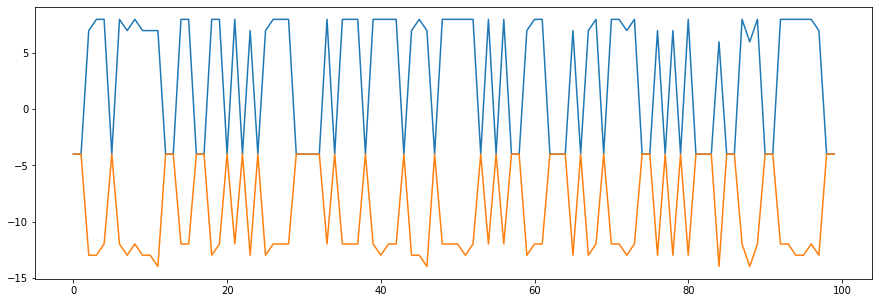

In [62]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

Let's let it run for more games.

In [69]:
rlg, rew, starts, states = experiment(rlglue, runs)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:24<00:00, 97.94it/s]


In [70]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(11251, 0)

I let it run for another 80k, and it seems we're down to losing only half the time. Which is guess is the best that this agent can do.

In [97]:
(rew[np.where(starts==-1), 0] > 0).sum(), (rew[np.where(starts==1), 0] > 0).sum()

(9622, 1629)

We can see that Exact agent had it easier when he started. He only won 1629 games from 20k where the NN agent started.

Let's play a game:

In [121]:
ai = rlg.agents[1]["agent"] # our agent is now the 1. 

In [135]:
env = TicTacToeEvnironment()
env.env_init()
ret = env.env_start()

In [136]:
action = ai.agent_start(ret[0], ret[1])
action # ai chooses...

0

In [137]:
ret = env.env_step(1, action)

In [138]:
# Human (aka - me) will play 4
ret = env.env_step(-1, 4)

In [139]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

2

In [140]:
ret = env.env_step(1, action)

In [141]:
# Human (aka - me) will block: 1
ret = env.env_step(-1, 1)

In [142]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

7

In [143]:
ret = env.env_step(1, action) # not a bad block

In [144]:
# I choose 5
ret = env.env_step(-1, 5)

In [145]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

3

In [146]:
ret = env.env_step(1, action) # again, a good block

In [147]:
# I choose 8
ret = env.env_step(-1, 8)

In [148]:
action = ai.agent_step(-1, ret[1], ret[3])
action # ai chooses...

6

In [149]:
env.env_step(1, action)

(10,
 array([ 1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.]),
 True,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0.]))

So I kind of let the agent win. It really felt like the agent wasn't really trying to win, but more block me... Maybe that's the bad thing about playing against a too strong of an opponent. 

Let's try again, this time the NN agent against itself:

In [7]:
# define the function approximator - a Feed-Forward NN 
layers1 = [9, 12, 12, 9]
layers2 = [9, 12, 12, 9]
nn1 = SimpleKerasNN(layers1)
nn2 = SimpleKerasNN(layers2)

In [8]:
def experiment(runs, nns):
    rlglue = RLGlue(TicTacToeEvnironment, TicTacToeNNAgent, TicTacToeNNAgent)
    rewards = np.zeros((runs, 2))
    starts = np.zeros((runs, 1))
    final_states = np.zeros((runs, 9))
    agent1_info = {"discount": 1, "network": nns[0], "tau": 1, "num_actions": 9, "seed": 747}
    agent2_info = {"discount": 1, "network": nns[1], "tau": 1, "num_actions": 9, "seed": 101}
    env_info = {}
    rlglue.rl_init(agent1_info, agent2_info, env_info)

    for i in tqdm(range(runs)):
        rlglue.rl_episode(10)
        rewards[i, :], starts[i, :], final_states[i, :] =  rlglue.rl_return()
    return rlglue, rewards, starts, final_states

In [14]:
runs = 30000

In [15]:
rlg, rew, starts, states = experiment(runs, [nn1, nn2])

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:57<00:00, 83.90it/s]


In [13]:
(rew[:,0] > 0).sum() , (rew[:,1] > 0).sum()

(4709, 5102)

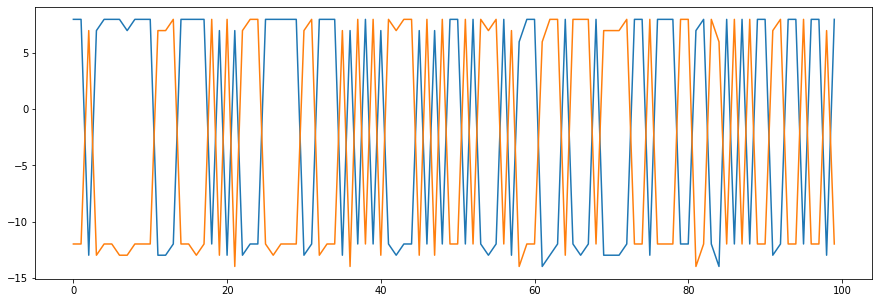

In [12]:
plt.figure(figsize=(15,5))
plt.plot(rew[-100:,])
plt.show()

Doesn't seem to be working that great. I guess in this architecture, the agent just doesn't have enough capacity to learn enough...

In [69]:
# let's save this agent
ai.network.model.save_weights("agent-4-keras-9-12-12-9.h5")